# The Project #
1. This is a project with minimal scaffolding. Expect to use the the discussion forums to gain insights! It’s not cheating to ask others for opinions or perspectives!
2. Be inquisitive, try out new things.
3. Use the previous modules for insights into how to complete the functions! You'll have to combine Pillow, OpenCV, and Pytesseract
4. There are hints provided in Coursera, feel free to explore the hints if needed. Each hint provide progressively more details on how to solve the issue. This project is intended to be comprehensive and difficult if you do it without the hints.

### The Assignment ###
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./readonly/small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](./readonly/large_project.png)

Note: That big file can take some time to process - for me it took nearly ten minutes! Use the small one for testing.

In [1]:
from zipfile import ZipFile 
from PIL import Image, ImageDraw, ImageOps
import pytesseract
import cv2 as cv
import numpy as np
import io
import math
import kraken
from kraken import binarization
from string import punctuation
set(punctuation)

# loading the face detection classifier
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')

In [ ]:
### loading in images__done
image_lib_small = {}
image_lib_large = {}

fn1 = "readonly/small_img.zip"
with ZipFile(fn1, 'r') as zip:
    for name in zip.infolist():
        with zip.open(name) as file:
            img = Image.open(file).convert('RGB')
            image_lib_small[name.filename] = {'imgPIL':img}
            imgCV = cv.cvtColor(np.array(image_lib_small[name.filename]['imgPIL']),cv.COLOR_BGR2GRAY)
            image_lib_small[name.filename]['imgCV'] = imgCV
            
fn2 = "readonly/images.zip"
with ZipFile(fn2, 'r') as zip:
    for name in zip.infolist():
        with zip.open(name) as file:
            img = Image.open(file).convert('RGB')
            image_lib_large[name.filename] = {'imgPIL':img}
            imgCV = cv.cvtColor(np.array(image_lib_large[name.filename]['imgPIL']),cv.COLOR_BGR2GRAY)
            image_lib_large[name.filename]['imgCV'] = imgCV

In [2]:
### image binarization for OCR__done
def bin_images(image_dict):
    for image in image_dict.keys():
        image_dict[image]['imgPIL_bin'] = kraken.binarization.nlbin(image_dict[image]['imgPIL'])
        print('{} binarized for OCR'.format(image))
    return

In [3]:
### text tokenization__done
def txt_processing(image_dict):
    for image in image_dict.keys():
        text = pytesseract.image_to_string(image_dict[image]['imgPIL_bin'])
        lwd = text.lower()
        for char in punctuation:
            if char in lwd:
                lwd = lwd.replace(char,"")
        despaced = lwd.replace('\n',' ')
        words = despaced.split()
        image_dict[image]['words'] = words
        print('{} text tokenized'.format(image))
    return

In [4]:
### keyword search__done
def txt_search(image_dict, searchterm):
    search = searchterm.lower()
    for image in image_dict.keys():
        if search in image_dict[image]['words']:
            image_dict[image]['found'] = True
            print('keyword found in {}'.format(image))
        else:
            image_dict[image]['found'] = False
            print('keyword not found in {}'.format(image))
    return

In [5]:
### face search__done
def find_faces(image_dict):
    for image in image_dict.keys():
        face_det = face_cascade.detectMultiScale(image_dict[image]['imgCV'],scaleFactor=1.20,minNeighbors=6)
        tmp = []
        for x,y,w,h in face_det:
            tmp.append(image_dict[image]['imgPIL'].crop((x,y,x+w,y+h)))
        image_dict[image]['faces'] = tmp
        print('finding faces in {}'.format(image))
    return

In [6]:
#create thumbnails__done
def thumbnail(image_dict):
    for image in image_dict.keys():
        for face in image_dict[image]['faces']:
            face.thumbnail((100,100))
    return

In [7]:
#return results__done
def results(image_dict):
    for image in image_dict.keys():
        if image_dict[image]['found'] == True:
            if(len(image_dict[image]['faces']) != 0):
                print("Result found in file {}".format(image))
                h = math.ceil(len(image_dict[image]['faces'])/5)
                contact_sheet=Image.new('RGB',(500, 100*h))
                x = 0
                y = 0
                for img in image_dict[image]['faces']:
                    contact_sheet.paste(img, (x, y))
                    if x+100 == contact_sheet.width:
                        x=0
                        y+=100
                    else:
                        x+=100      
                display(contact_sheet)
            else:
                print("Result found in file {} \nBut there were no faces in that file\n\n".format(image))
    return

In [8]:
def wordstofaces(filestr, searchtermstr):
    image_lib = {}

    fn = filestr
    with ZipFile(fn, 'r') as zip:
        for name in zip.infolist():
            with zip.open(name) as file:
                img = Image.open(file).convert('RGB')
                image_lib[name.filename] = {'imgPIL':img}
                imgCV = cv.cvtColor(np.array(image_lib[name.filename]['imgPIL']),cv.COLOR_BGR2GRAY)
                image_lib[name.filename]['imgCV'] = imgCV
    bin_images(image_lib)
    txt_processing(image_lib)
    txt_search(image_lib, searchtermstr)
    find_faces(image_lib)
    thumbnail(image_lib)
    results(image_lib)
    return

a-0.png binarized for OCR
a-1.png binarized for OCR
a-2.png binarized for OCR
a-3.png binarized for OCR
a-0.png text tokenized
a-1.png text tokenized
a-2.png text tokenized
a-3.png text tokenized
keyword found in a-0.png
keyword not found in a-1.png
keyword not found in a-2.png
keyword found in a-3.png
finding faces in a-0.png
finding faces in a-1.png
finding faces in a-2.png
finding faces in a-3.png
Result found in file a-0.png


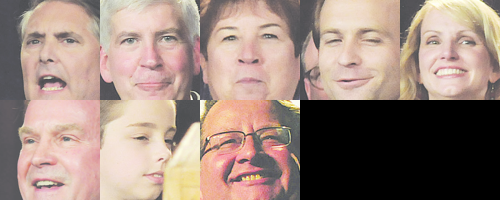

Result found in file a-3.png


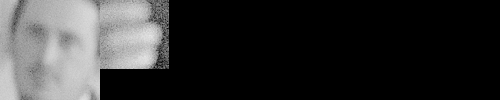

In [9]:
wordstofaces("readonly/small_img.zip", 'Christopher')

a-0.png binarized for OCR
a-1.png binarized for OCR
a-10.png binarized for OCR
a-11.png binarized for OCR
a-12.png binarized for OCR
a-13.png binarized for OCR
a-2.png binarized for OCR
a-3.png binarized for OCR
a-4.png binarized for OCR
a-5.png binarized for OCR
a-6.png binarized for OCR
a-7.png binarized for OCR
a-8.png binarized for OCR
a-9.png binarized for OCR
a-0.png text tokenized
a-1.png text tokenized
a-10.png text tokenized
a-11.png text tokenized
a-12.png text tokenized
a-13.png text tokenized
a-2.png text tokenized
a-3.png text tokenized
a-4.png text tokenized
a-5.png text tokenized
a-6.png text tokenized
a-7.png text tokenized
a-8.png text tokenized
a-9.png text tokenized
keyword found in a-0.png
keyword found in a-1.png
keyword found in a-10.png
keyword not found in a-11.png
keyword not found in a-12.png
keyword not found in a-13.png
keyword found in a-2.png
keyword found in a-3.png
keyword not found in a-4.png
keyword found in a-5.png
keyword not found in a-6.png
keyword

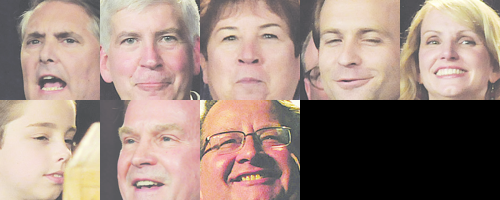

Result found in file a-1.png


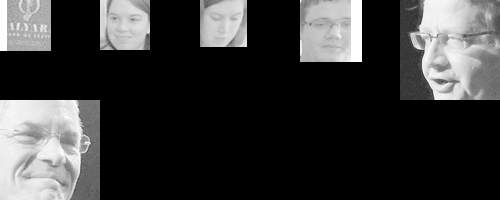

Result found in file a-10.png 
But there were no faces in that file


Result found in file a-2.png


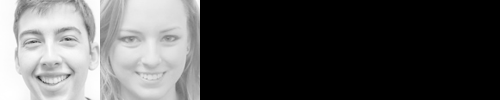

Result found in file a-3.png


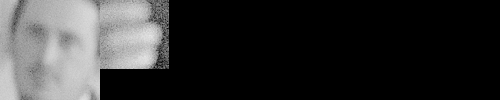

Result found in file a-5.png


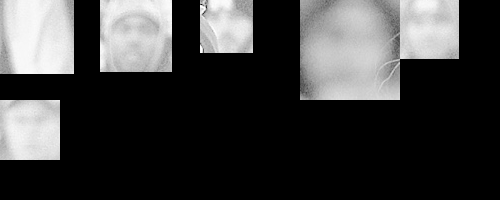

Result found in file a-8.png


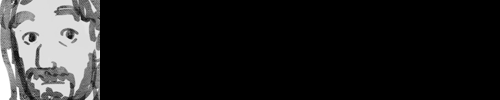

Result found in file a-9.png


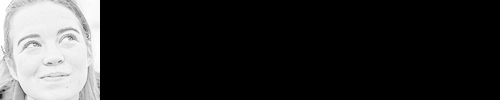

In [10]:
wordstofaces("readonly/images.zip", 'Mark')